## The main task is to do the spectral analysis of TAVG measurements in India.

In [ ]:
%load_ext autoreload
!pip3 install ipyleaflet
!pip3 install matplotlib

In [2]:
country = 'India'
meas = 'TAVG'
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [3]:
# Prepare python libraries for distribution to executors
# !tar -czvf lib.tgz lib/*.py


# start sparkContext
import pandas as pd
import numpy as np
import sklearn as sk
import urllib
import math

import pyspark
from pyspark import SparkContext, SparkConf
from lib import sparkConfig

conf = SparkConf()
conf.set('spark.ui.showConsoleProgress', False)
sc = SparkContext(conf=conf, pyFiles = ['lib.tgz'])

# sc = SparkContext(pyFiles=['lib.tgz'])
#master="local[10]"
print('sparkContext=',sc)
print()

# start sqlContext
from pyspark.sql import *
import pyspark.sql
sqlContext = SQLContext(sc)

#load libraries
import numpy as np
from lib.numpy_pack import packArray,unpackArray,unpackAndScale
from lib.spark_PCA import computeCov
from lib.computeStatistics import *

_figsize=(10,7)

### Load the required libraries

from lib.YearPlotter import YearPlotter
from lib.decomposer import *
from lib.Reconstruction_plots import *

from lib.import_modules import import_modules,modules
import_modules(modules)

# import widgets library
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, fixed, interact_manual,widgets
import ipywidgets as widgets

import warnings  # Suppress Warnings
warnings.filterwarnings('ignore')

## Change the paths here to account for current location of parquest files
## load measurement and stations dataframe
_uname = os.getcwd().split('/')[2]

print("Username =", _uname)
parquet_root= f'/home/{_uname}/public/Datasets_public/'


measurements_path=parquet_root+'/weather-parquet'
measurements=sqlContext.read.parquet(measurements_path)
sqlContext.registerDataFrameAsTable(measurements,'measurements')

print('measurements is a Dataframe (and table) with %d records'%(measurements.count()))

stations_path=parquet_root+'/stations-parquet'
stations=sqlContext.read.parquet(stations_path)
sqlContext.registerDataFrameAsTable(stations,'stations')
print('stations is a Dataframe (and table) with %d records'%(stations.count()))

weather=measurements.join(stations,on='station')
print('weather is a Dataframe (and table) which is a join of measurements and stations with %d records'%(weather.count()))
sqlContext.registerDataFrameAsTable(weather,'weather')

10.43.192.8


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).


23/05/13 22:07:51 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
23/05/13 22:07:52 WARN Utils: Untarring behavior will be deprecated at spark.files and SparkContext.addFile. Consider using spark.archives or SparkContext.addArchive instead.
sparkContext= <SparkContext master=local[*] appName=pyspark-shell>



/opt/bitnami/spark/python/pyspark/sql/context.py:112: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


    pandas as    pd 	version=2.0.1 	required version>=0.19.2

     numpy as    np 	version=1.24.3 	required version>=1.12.0

   sklearn as    sk 	version=1.2.2 	required version>=0.18.1

module urllib has no version
   pyspark as pyspark 	version=3.3.1 	required version>=2.1.0

ipywidgets as ipywidgets 	version=8.0.6 	required version>=6.0.0

Username = m7ma
23/05/13 22:07:54 WARN Utils: Untarring behavior will be deprecated at spark.files and SparkContext.addFile. Consider using spark.archives or SparkContext.addArchive instead.
measurements is a Dataframe (and table) with 12720632 records
stations is a Dataframe (and table) with 119503 records
weather is a Dataframe (and table) which is a join of measurements and stations with 12720632 records


In [4]:
import pickle
import os

ms = ['TMAX', 'TMIN', 'TAVG']
_uname = os.getcwd().split('/')[2]

print("Username =", _uname)
parquet_root= f'/home/{_uname}/public/Datasets_public/'

pkl_filename = f'/home/{_uname}/public/Datasets_public/{country}-{",".join(ms)}.pkl'
with open(pkl_filename,'br') as pkl_file:
    STAT = pickle.load(pkl_file)

Username = m7ma


## Part 1: Exploring the PCA decomposition

In this section, we want to construct approximations of TAVG measurements in India using the mean and the 2 top eigenvectors. **Each TAVG measurement is a list of average temperature values measured in a weather station for all days (366 days) in a year.**

- `EigVec` is a matrix of shape (366, 2), in which each column is a eigenvector of all the TAVG measurements in India.
- `Mean` is a vector of length 366 that has the average TAVG measurements across all stations in India. 

In [5]:
k = 2
EigVec = np.array(STAT[meas]['eigvec'][:,:k])
Mean = STAT[meas]['Mean']

First we want to plot the mean and the 2 top eigenvectors as functions of time (days of a year).

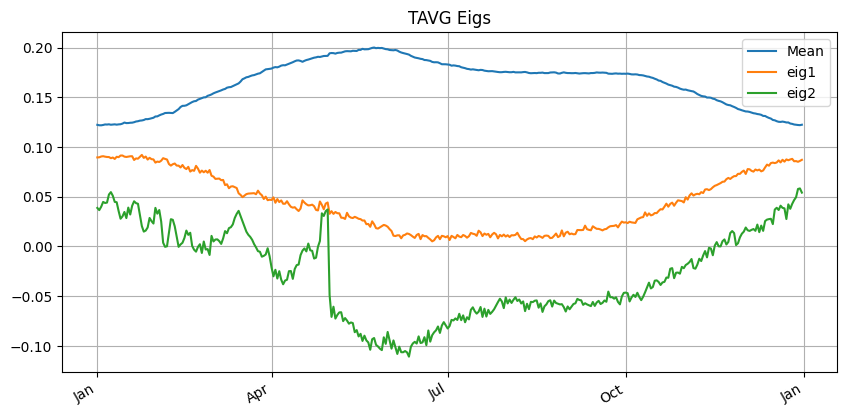

In [6]:
_norm_Mean = Mean / max(Mean) * 0.2 # Combine mean with Eigvecs and scale to similar range.
A = [_norm_Mean] + [EigVec[:,i] for i in range(EigVec.shape[1])]
Combined = np.stack(A).transpose()
fig, axes = plt.subplots(1, 1, sharex='col', sharey='row', figsize=(10,5)); 

YearPlotter().plot(Combined, fig, axes, title=meas+' Eigs', labels=['Mean'] + ['eig'+str(i+1) for i in range(k)])

### Problem 1: Plot percentage of variance explained

Given that all the eigenvalues are stored in `eigvals`, plot the percentage of the variance explained by the first 10 eigenvectors.

#### Task:

Calculate the numpy array `cumvar_10`.The element of `cumvar_10` on index $i$ is the percentage of the variance explained by the first $i$ eigenvectors. Note that each value in `cumvar_10` should be a value from 0 to 100. Check the correctness of your solution by comparing your graph with the graph shown above. 

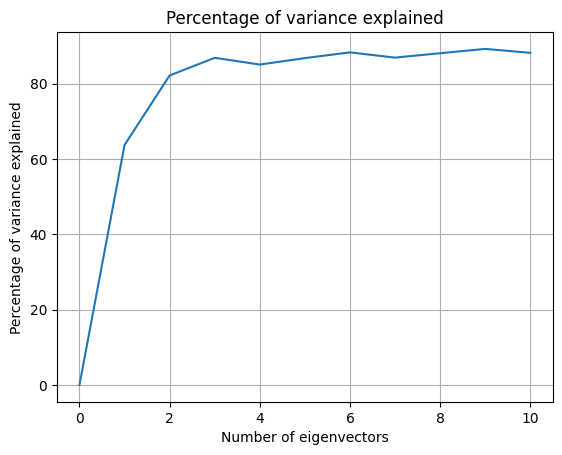

In [7]:
eigvals = STAT[meas]['eigval']

total_variance = np.sum(eigvals)
explained_variance = eigvals[:10] / total_variance * 100
cumvar_10 = [0]
for i in range(len(explained_variance)):
    cumvar_10.append(cumvar_10[i] + explained_variance[i])
cumvar_10 = np.array(cumvar_10)
fig,ax=plt.subplots(1,1);
ax.plot(cumvar_10); 
ax.grid(); 
ax.set_ylabel('Percentage of variance explained')
ax.set_xlabel('Number of eigenvectors')
ax.set_title('Percentage of variance explained');

Here we construct a Spark DataFrame `df2`, in which each row is a TAVG measurement from a weather station in India. We will be focusing on these columns of `df2` in this notebook:

- `Values`: the TAVG temperature measurement, which is a list of the average temperatures for 366 days in a year (encoded in a byte array).
- `coeff_[i]`: the projection coefficient in front of the `[i]`th eigenvector in the eigen-decomposition of `Values`.
- `res_[i]`: the normalized residual norm of the approximation using the top `[i]` eigenvector.
- `Station`: the id of the station from which the measurement was collected.
- `latitude`, `longitude`: the latitude and longitude of the station.

In [8]:
Query="""
select *
from weather
WHERE country='%s' and measurement='%s'
""" % (country, meas)
df = sqlContext.sql(Query)

df2 = decompose_dataframe(sqlContext, df, EigVec, Mean).cache()
df2.show(2)

+-----------+-----------+----+--------------------+--------+---------+---------+----------+-------------+-----+-------+---------+--------------------+------------------+------------------+-------------------+----------------+
|    Station|Measurement|Year|              Values|latitude|longitude|elevation|dist2coast|         name|state|country|total_var|            res_mean|             res_1|           coeff_1|              res_2|         coeff_2|
+-----------+-----------+----+--------------------+--------+---------+---------+----------+-------------+-----+-------+---------+--------------------+------------------+------------------+-------------------+----------------+
|IN001020700|       TAVG|2022|[F6 00 F3 00 EB 0...|  14.583|   77.633|    364.0|     266.0|PBO ANANTAPUR|     |  India|7081450.0|0.027627345839496005| 0.274357596601503|311.81902552000804|0.25047353511881104|74.9343199727578|
|IN001111200|       TAVG|2022|[FE 00 FA 00 F4 0...|    16.2|    81.15|      3.0| 7.9765625|MACHI

Then we will study what information `coeff_1` and `coeff_2` can tell us.

For each coefficient, 

1. We first filter out the rows where the approximation residuals are too large.
1. Then we sort the rows according to the coefficient values in the increasing order.
1. Last we plot the rows that have lowest and highest coefficient values. 

Each figure below plots the approximations of each measurement (each row in `df2`). 

- `mean`: the `Mean` variable.
- `target`: the `Values` feild of the measurement. 
- `approx [i]`: the approximation using the first `[i]` eigenvectors. 
- `c[i]`, `r[i]`: the values of `coeff_[i]`, `res_[i]`.

In [9]:
# Filter and sort according to coeff_1
coeff1_rows = df2.filter(df2.res_1 < 0.3).sort(df2.coeff_1).collect()

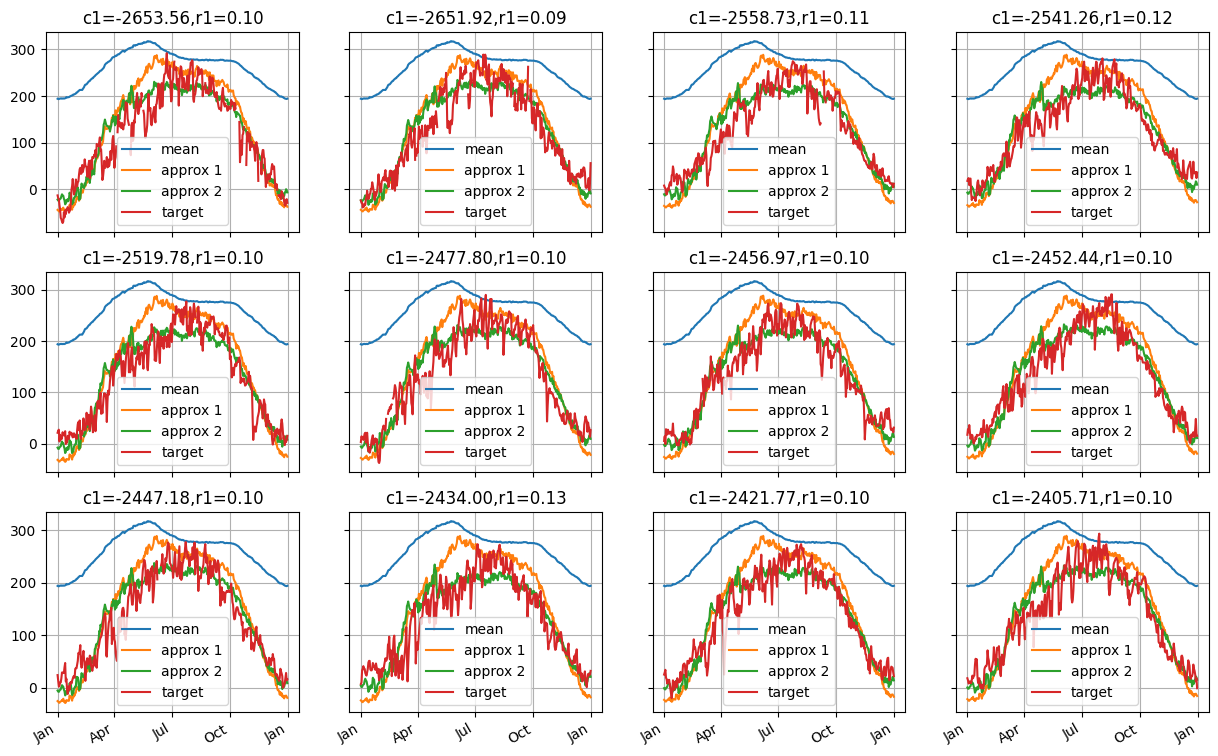

In [10]:
# Measurements with lowest 12 coeff_1
plot_recon_grid(coeff1_rows[0:12], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

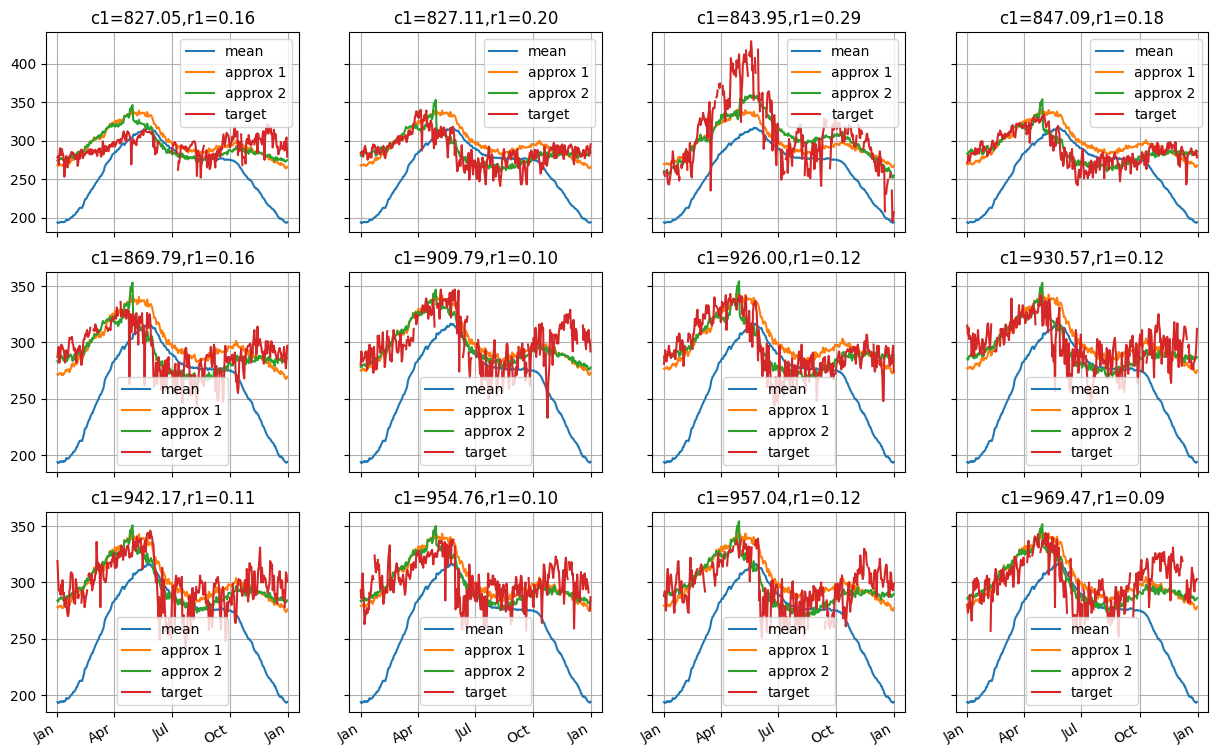

In [11]:
# Measurements with highest 12 coeff_1
plot_recon_grid(coeff1_rows[-12:], Mean, EigVec, header='c1=%3.2f,r1=%3.2f', params=('coeff_1','res_1'))

In [12]:
# Filter and sort according to coeff_2
coeff2_rows = df2.filter(df2.res_2 < 0.11).filter(df2.res_1 > 0.2).sort(df2.coeff_2).collect()

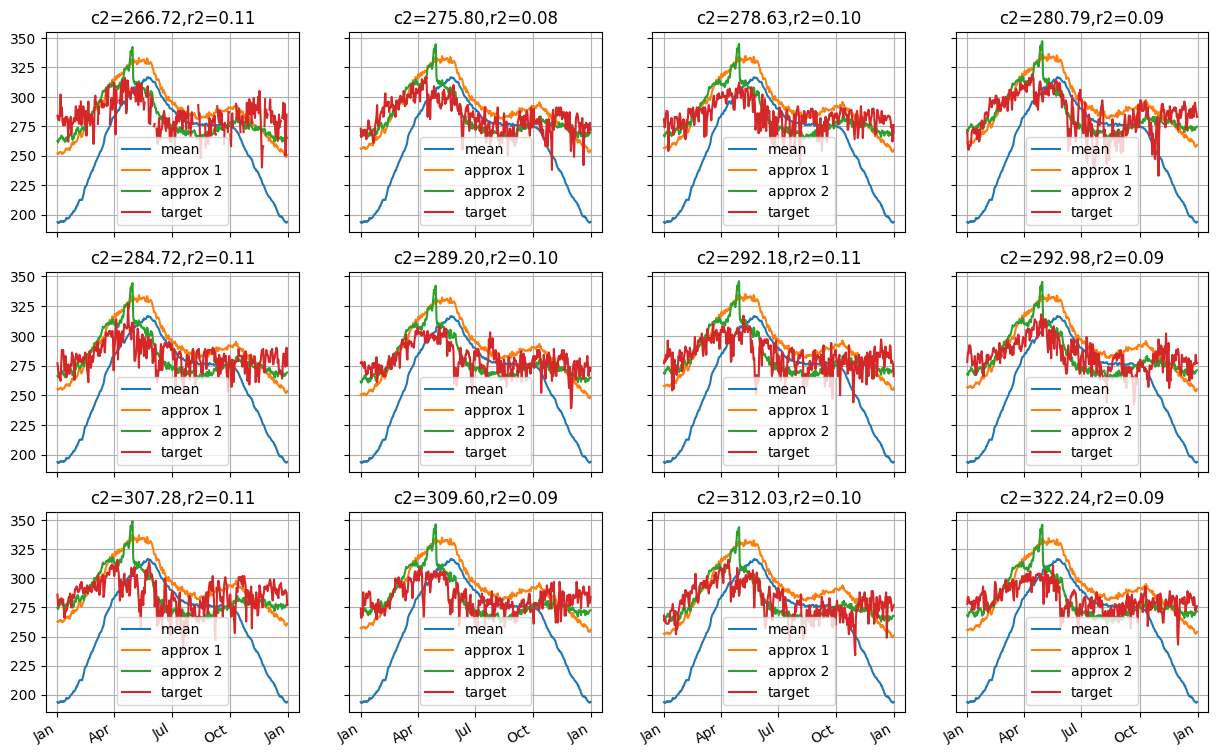

In [13]:
# Measurements with lowest 12 coeff_2
plot_recon_grid(coeff2_rows[0:12], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

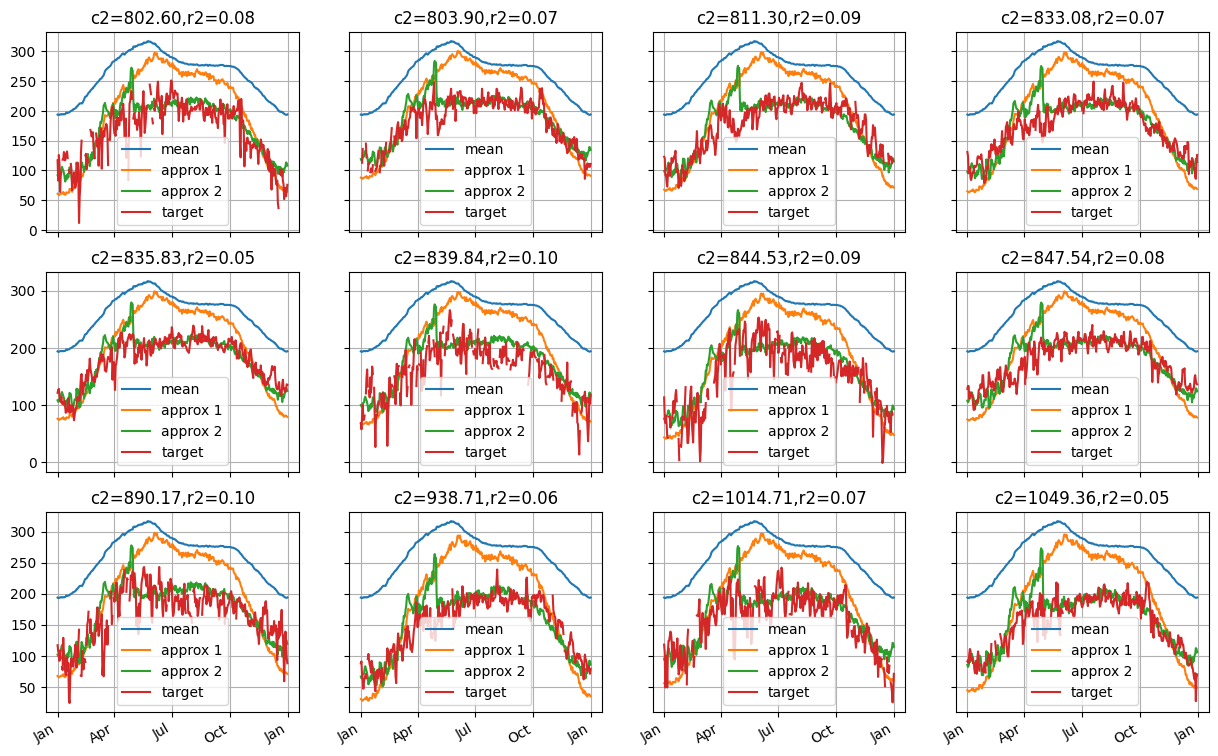

In [14]:
# Measurements with highest 12 coeff_2
plot_recon_grid(coeff2_rows[-12:], Mean, EigVec, header='c2=%3.2f,r2=%3.2f',params=('coeff_2','res_2'))

Instead of plotting the measurements with lowest and highest coefficients, we can just visualize any measurement and its approximations in an interactive plot, where the different approximations can be seen by manually changing the projection coefficients.

In [15]:
# Here we select the measurement (row) with highest `coeff_2`.
row = coeff2_rows[-1]

target = np.array(unpackArray(row.Values,np.int16), dtype=np.float64)
eigen_decomp = Eigen_decomp(None, target, Mean, EigVec)
total_var, residuals,coeff = eigen_decomp.compute_var_explained()
res = residuals[1]
print('residual normalized norm  after mean:', res[0])
print('residual normalized norm  after mean + top eigs:', res[:])

plotter = recon_plot(eigen_decomp,year_axis = True,interactive = True)
display(plotter.get_Interactive())

residual normalized norm  after mean: 0.48807580115566984
residual normalized norm  after mean + top eigs: [0.4880758  0.30144218 0.05103543]


## Part 2: Partitioning the `coeff_1`, `coeff_2` plane 

If we view `coeff_1` as the x-axis and `coeff_2` as the y-axis, we can find that the distribution of the coefficients of the first 2 eigenvectors in `df2` shows some clusters. In this section, we will analyze the coefficients by grouping them toghether.

First, we define 7 clusters and manually choose the centers of for these clusters. In each center, the first element defines the center for `coeff_1` and the second element defines the center for `coeff_2`. 

In [16]:
centers = {
    '0': (0, 0),
    '1': (-250, -250),
    '2': (500, 0),
    '3': (500, 400),
    '4': (-100, 600),
    '5': (-1500, 500),
    '6': (-200, 100)
}

C = []
for key in centers:     
    C.append(centers[key])
C = stack(C)

### Problem 2

Here we are doing several things that are useful later:

1. Convert `df2` to `df3` by grouping the measurements that are from the same `Station`. Each row of `df3` is a station with its `Station`, `Longitude`, `Latitude` and average values of `coeff_1`, `coeff_2` of the measurements from the station.
1. Count the number of measurements for each `Station` and store the results in `station_counts`.
1. Get `pdf` by merging (join) `df3` and `station_counts` on column `Station`.

Note `pdf` is a pandas DataFrame instead of Spark DataFrame to allow less constrained queries.

#### Task:

Write the code that converts `df2` to `df3` (first point above). 
- The `coeff_1` and `coeff_2` columns are grouped by taking the average.
- The `Longitude` and `Latitude` columns are grouped by taking the average or selecting any of them, since the same `Station` will have the same `Longitude` and `Latitude`.
- The rest of the columns in `df2` are discarded.
- `df3` should have 5 columns: `Station`, `coeff_1`, `coeff_2`, `Longitude`, and `Latitude`. 
- Spark DataFrame API will be used.


In [17]:
# YOUR CODE HERE
df3 = df2.select("Station", "coeff_1", "coeff_2", "Longitude", "Latitude").groupBy("Station").avg("coeff_1", "coeff_2", "Longitude", "Latitude") \
        .withColumnRenamed("avg(coeff_1)", "coeff_1").withColumnRenamed("avg(coeff_2)", "coeff_2") \
        .withColumnRenamed("avg(Longitude)", "Longitude").withColumnRenamed("avg(Latitude)", "Latitude")
pdf3 = df3.toPandas().sort_values('Station')
station_counts = df2.groupBy('Station').count()
pdf = pdf3.merge(station_counts.toPandas(), on='Station')
print(f'There are in total {pdf.shape[0]} stations')

# Assign shorter names to the columns
pdf.columns=['Station', 'coeff_1', 'coeff_2', 'Longitude', 'Latitude', 'count']
pdf.head()

There are in total 183 stations


,Station,coeff_1,coeff_2,Longitude,Latitude,count
0,IN001020700,501.828895,56.073761,77.633,14.583,52
1,IN001050200,440.247446,-10.410478,82.233,16.950,50
2,IN001080500,269.624439,135.317346,78.470,17.450,54
3,IN001090500,318.556718,-95.619204,79.433,18.767,49
4,IN001111200,428.893895,-43.875230,81.150,16.200,50


### Problem 3

In this cell, we want to group the stations to their closest center that we defined eariler and add their groups to `pdf` DataFrame.

#### Task:

Given `coeffs`, in which each row contains the `(coeff_1, coeff_2)` of each station, find the index of centers in numpy array `C` that is closest (minimum euclidean distance) to the `(coeff_1, coeff_2)` of each station. Store the results in variable `group`, in which the value in index `i` is the index of the nearest center for `Station i` in `pdf`. 

In [18]:
from scipy.spatial.distance import cdist

coeffs = np.array(pdf[['coeff_1','coeff_2']])

# YOUR CODE HERE
group = cdist(coeffs, C)
group = np.argmin(group, axis=1)
pdf['group'] = group
pdf.head()

,Station,coeff_1,coeff_2,Longitude,Latitude,count,group
0,IN001020700,501.828895,56.073761,77.633,14.583,52,2
1,IN001050200,440.247446,-10.410478,82.233,16.950,50,2
2,IN001080500,269.624439,135.317346,78.470,17.450,54,2
3,IN001090500,318.556718,-95.619204,79.433,18.767,49,2
4,IN001111200,428.893895,-43.875230,81.150,16.200,50,2


### Problem 4

Below (after 2 cells) is a scatter plot of the average two first coefficients for each station. 
- The size of the dot indicates the number of measurements of the station (`count` column). 
- The color indicates the group to which the station belongs, which is determined by the index of the closest center.
    - 0: 'red', 1: 'orange', 2: 'yellow', 3: 'green', 4: 'grey', 5: 'blue', 6: 'purple'
- The numbers in text are the group numbers, which are positioned in the cluster center. 

#### Task:

Follow the steps described below to use `pdf` to draw the plot shown above.
1. Use [`pandas.DataFrame.plot.scatter`](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.plot.scatter.html?highlight=example) to draw the scatters.
    - **Use `c=pdf.group.map(lambda x: cmap[x])` and `figsize=[15, 10]` as the parameters when calling this function to match the scatter colors and figure size.** 
1. Use [`matplotlib.pyplot.text`](https://matplotlib.org/3.5.0/api/_as_gen/matplotlib.pyplot.text.html), which is already loaded as `text` function, and cluster centers `C` to draw the group number texts.
    - **Use `color='black'` and `size=20` as the parameters when calling this function to match the text colors and text size.**

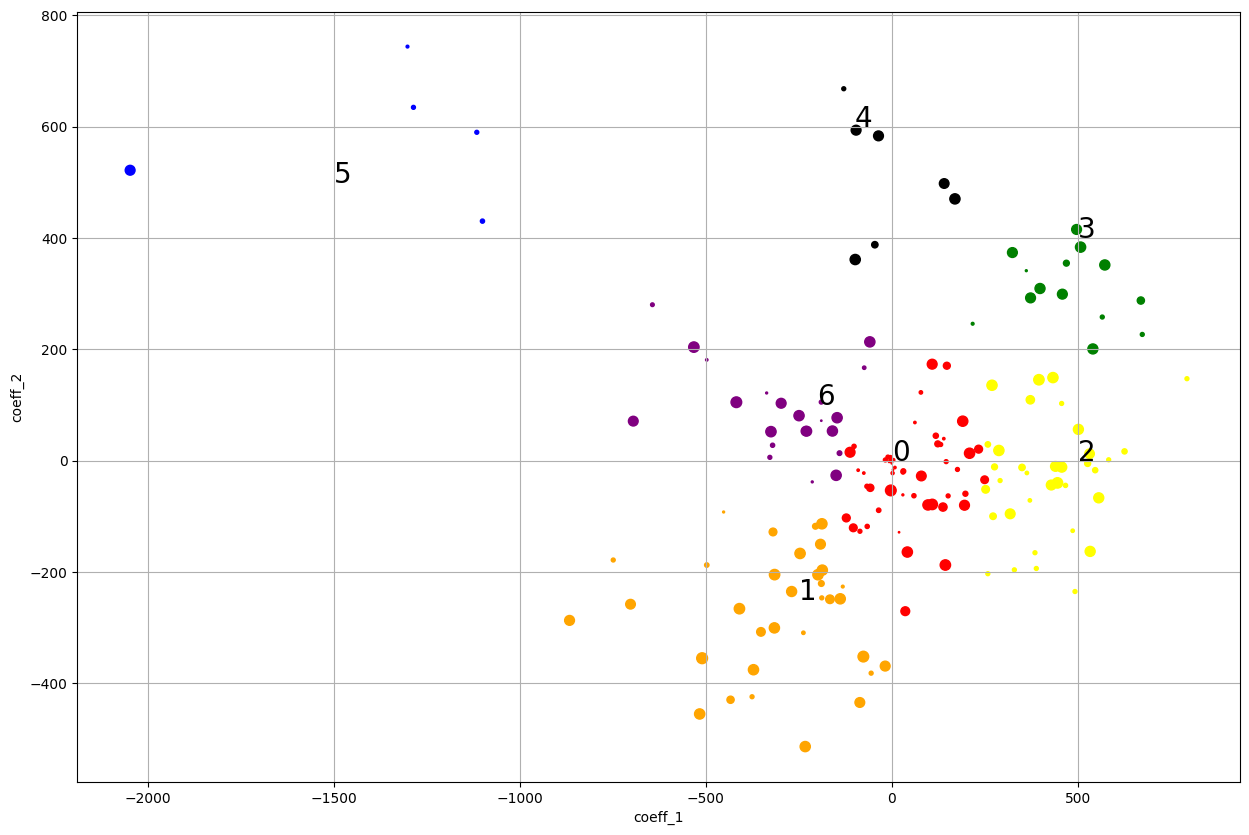

In [19]:
cmap = ['red', 'orange', 'yellow', 'green', 'black', 'blue', 'purple']
# YOUR CODE HERE
pdf.plot.scatter(x='coeff_1', y='coeff_2', s=pdf["count"], c=pdf.group.map(lambda x: cmap[x]), figsize=[15, 10])

for i, center in enumerate(C):
    plt.text(center[0], center[1], str(i), color='black', size=20)
grid()

## Part 3: Visualizing the stations on the map

In this section, we will use [`ipyleaflet`](https://ipyleaflet.readthedocs.io/en/latest/index.html) to visualize the data of `pdf` on an interactive map. 

### Problem 5

Below (after 2 cells) you can see a screenshot of the map where the each circle represents a station. 
- Again the color and the size of the cirlces represent the number of measurements from the station and the group that the station belongs to. 
- The blue rectangle defines the boundary of the stations appeared in the map.
- Note: the coordinate system used in the map is (latitude, longtitude).


#### Task:

1. Step 1:
    1. Find the bounding box of the longtitude and latitude in the `pdf` DataFrame
    2. Find the center `(latitude, longtitude)` of the bounding box and store it in the `center` variable.
1. Step 2 (provided in the starter code):
    1. Construct the ipyleaflet `Map` object
1. Step 3:
    1. Construct the blue `Rectangle` object as the bounding box and add it to the map. 
        - Only need to use the `bounds` and `fill_opacity` parameters of `Rectangle`.
1. Step 4:
    1. For each row of the `pdf` DataFrame, add a `Circle` object to represent a station to the map. 
    Here are the instructions for the parameters of `Circle`.
        - Use `weight=1`,`opacity=0.7`, and `fill_opacity=0.7`.
        - Use $4800 \times \sqrt{count}$ for `radius`, where $count$ is the `count` of the station. 
        You might want to convert the result to an integer.
        - Use the list `cmap` and the group that the station belongs to determine the color for `fill_color` and `color`.
    1. Show the map

In [20]:
from ipyleaflet import (
    Map,
    Marker,
    TileLayer, ImageOverlay,
    Polyline, Polygon, Rectangle, Circle, CircleMarker,
    GeoJSON,
    DrawControl,
    basemaps, basemap_to_tiles
)

# Step 1
# YOUR CODE HERE
min_lat = min(pdf.Latitude)
max_lat = max(pdf.Latitude)
min_long = min(pdf.Longitude)
max_long = max(pdf.Longitude)
center = [(min_lat+max_lat)/2, (min_long+max_long)/2]

# Step 2
zoom = 5
m = Map(basemap=basemaps.OpenStreetMap.HOT, default_tiles=TileLayer(opacity=1.0), center=center, zoom=zoom)

# Step 3
# YOUR CODE HERE
south_west = (min_lat, min_long)
north_east = (max_lat, max_long)
rectangle = Rectangle(bounds=(south_west, north_east), fill_opacity=0)
m.add_layer(rectangle)

# Step 4
# YOUR CODE HERE
for index, row in pdf.iterrows():
    # Calculate the radius
    radius = int(4800 * (row['count'] ** 0.5))

    # Get the color for this group
    color = cmap[row['group']]

    # Define the circle
    circle = Circle()
    circle.location = (row['Latitude'], row['Longitude'])  # replace 'latitude' and 'longitude' with your actual column names
    circle.radius = radius
    circle.color = color
    circle.fill_color = color
    circle.weight = 1
    circle.opacity = 0.7
    circle.fill_opacity = 0.7

    # Add the circle to the map
    m.add_layer(circle)

# Step 5
m    

Map(center=[21.083, 82.23349999999999], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_ti…